In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y=mnist["data"], mnist["target"]
print(f"X shape: {X.shape}\n\ny Shape: {y.shape}")

X shape: (70000, 784)

y Shape: (70000,)


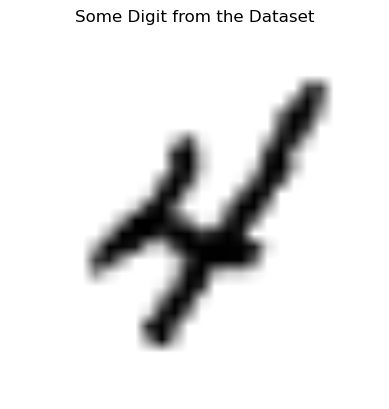

In [4]:
digit=X[9]
image=digit.reshape(28,28)

plt.title("Some Digit from the Dataset")
plt.imshow(image, cmap=mpl.cm.binary, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
y[9]

'4'

In [6]:
#change y from string to integers
y=y.astype(np.uint8)
y[9]

4

In [7]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure digits_plot


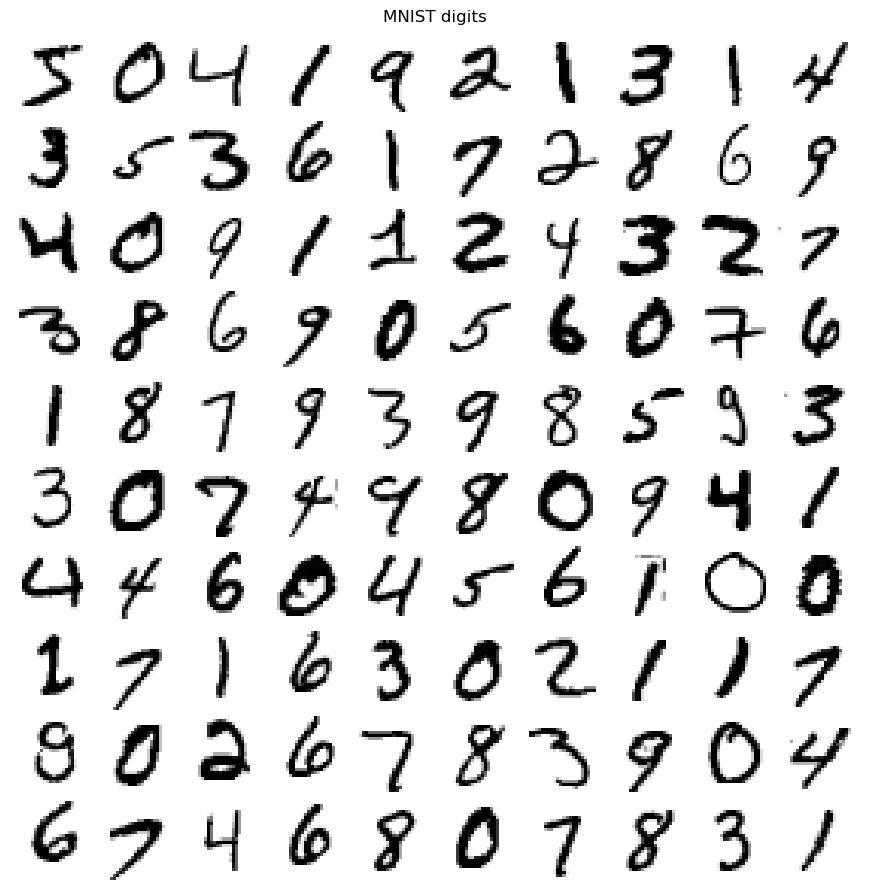

In [8]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.title("MNIST digits")
save_fig("digits_plot")
plt.show();

In [9]:
X_train, X_test, y_train, y_test= X[:60000], X[60000:], y[:60000], y[60000:]

### Binary Classifier

In [10]:
trainy_4=(y_train==4)
testy_4=(y_test==4)

- Stochastic Gradient Descent (SGD)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd=SGDClassifier(random_state=42)
sgd.fit(X_train, trainy_4)

SGDClassifier(random_state=42)

In [12]:
sgd.predict([digit])

array([ True])

#### Performance Metrics

- Cross-Validation

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X_train, trainy_4):
    clonee=clone(sgd)
    X_train_fold=X_train[train_index]
    y_train_fold=trainy_4[train_index]
    X_test_fold=X_train[test_index]
    y_test_fold=trainy_4[test_index]
    
    clonee.fit(X_train_fold, y_train_fold)
    y_pred=clonee.predict(X_test_fold)
    correct=sum(y_pred== y_test_fold)
    print(correct/ len(y_pred)*100)

95.15833333333333
97.55
97.65833333333333
97.79166666666667
97.81666666666666


In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd, X_train, trainy_4, cv=5, 
                scoring="accuracy")

array([0.97825   , 0.97225   , 0.96308333, 0.9725    , 0.97241667])

In [15]:
from sklearn.base import BaseEstimator

class Not4Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
not4=Not4Classifier()
cross_val_score(not4, X_train, trainy_4, cv=5,
               scoring="accuracy")

array([0.90133333, 0.90308333, 0.90333333, 0.90433333, 0.90108333])

#### Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd, X_train, trainy_4, cv=5)

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(trainy_4, y_train_pred)

array([[53283,   875],
       [  823,  5019]], dtype=int64)

Saving figure Confusion Matrix 4


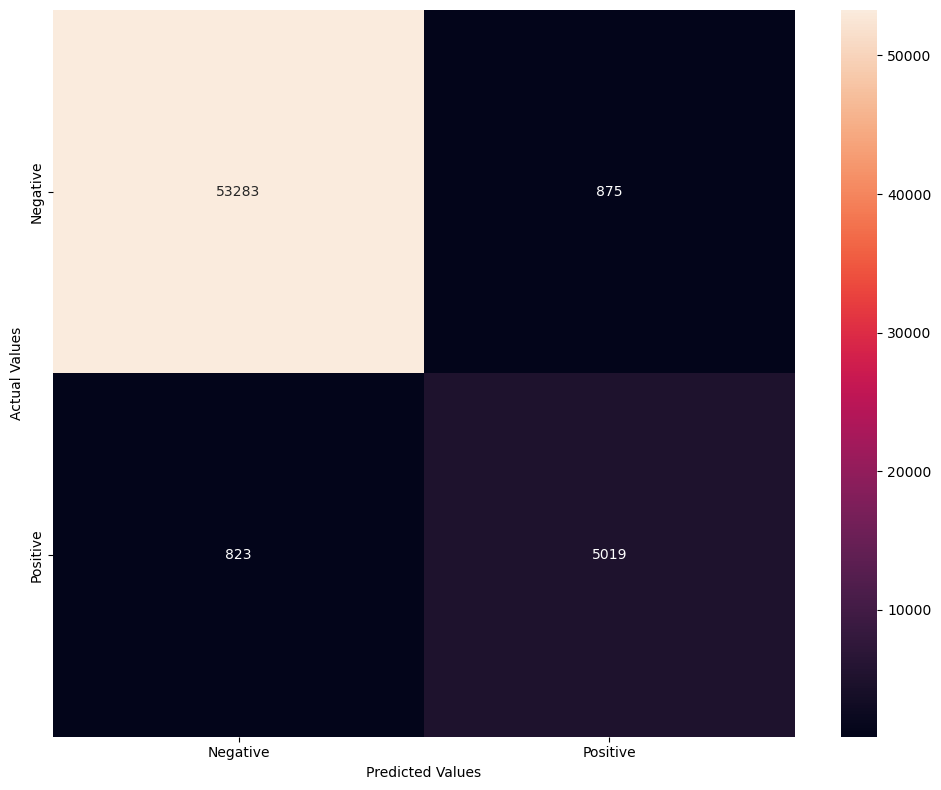

In [19]:
labels=["Negative", "Positive"]
cm=confusion_matrix(trainy_4, y_train_pred)

fig, ax=plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
plt.yticks(ticks=[0.5,1.5], labels=labels)
plt.ylabel("Actual Values")
plt.xticks(ticks=[0.5,1.5], labels=labels)
plt.xlabel("Predicted Values")
save_fig("Confusion Matrix 4")
plt.show();

#### Precision and Recall.

In [20]:
from sklearn.metrics import precision_score, recall_score

print(f"Precison Score: {precision_score(trainy_4, y_train_pred)}\n\nRecall Score: {recall_score(trainy_4, y_train_pred)}")

Precison Score: 0.8515439429928741

Recall Score: 0.8591235878123931


In [21]:
from sklearn.metrics import classification_report, f1_score

print(f"F1 Score: {f1_score(trainy_4, y_train_pred)}\n\nClassification Report: {classification_report(trainy_4, y_train_pred)}")

F1 Score: 0.8553169734151329

Classification Report:               precision    recall  f1-score   support

       False       0.98      0.98      0.98     54158
        True       0.85      0.86      0.86      5842

    accuracy                           0.97     60000
   macro avg       0.92      0.92      0.92     60000
weighted avg       0.97      0.97      0.97     60000



#### Precision and Recall Trade-off

In [22]:
y_scores=sgd.decision_function([digit])
y_scores

array([14090.84855953])

In [23]:
threshold= 0
y_digit_pred=(y_scores > threshold)
y_digit_pred

array([ True])

In [24]:
threshold=15000
y_digit_pred=(y_scores>threshold)
y_digit_pred

array([False])

In [25]:
y_scores=cross_val_predict(sgd, X_train, trainy_4, cv=5,
                          method="decision_function")

Saving figure precision_recall_vs_threshold_plot


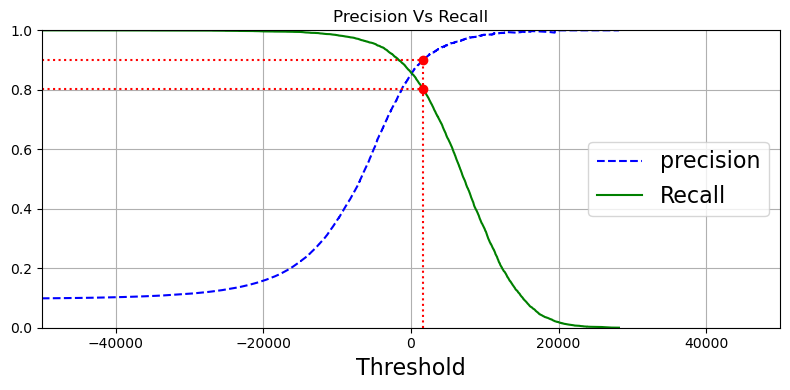

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds= precision_recall_curve(trainy_4, y_scores)

def plot(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.title("Precision Vs Recall")
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))   
plot(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")
plt.show()
    